In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

In [2]:
# Load dataset
data = pd.read_csv("Data/creditcard.csv")

# Explore
print(data.head())
print(data.describe())
print(data['Class'].value_counts())  # Only for exploration, not used for training


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

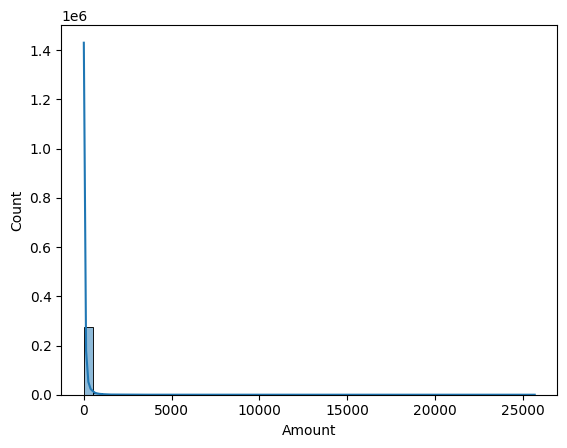

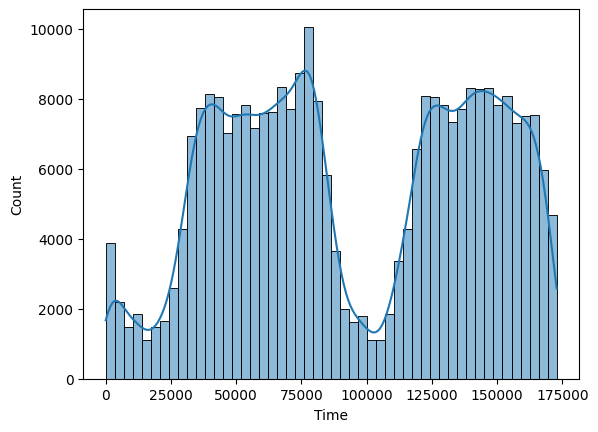

In [3]:
# Distribution plots
sns.histplot(data['Amount'], bins=50, kde=True)
plt.show()

sns.histplot(data['Time'], bins=50, kde=True)
plt.show()

### Step 2: Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop label for unsupervised training
X = data.drop('Class', axis=1)

In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

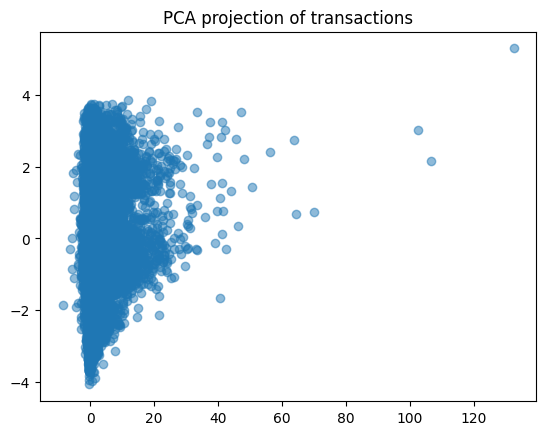

In [6]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title('PCA projection of transactions')
plt.show()


In [7]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.0017, random_state=42)  # approx fraud rate
y_pred_iso = iso.fit_predict(X_scaled)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]  # -1 = anomaly


In [8]:
#One-Class SVM
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.0017, kernel='rbf', gamma=0.01)
y_pred_svm = ocsvm.fit_predict(X_scaled)
y_pred_svm = [1 if i == -1 else 0 for i in y_pred_svm]


In [9]:
##Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np

In [10]:
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=256, validation_split=0.1)


Epoch 1/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9613 - val_loss: 0.8314
Epoch 2/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8523 - val_loss: 0.7929
Epoch 3/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8360 - val_loss: 0.7830
Epoch 4/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8278 - val_loss: 0.7769
Epoch 5/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8211 - val_loss: 0.7713
Epoch 6/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8162 - val_loss: 0.7662
Epoch 7/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8132 - val_loss: 0.7638
Epoch 8/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8110 - val_loss: 0.7617
Epoch 9/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8093 - val_loss: 0.7600
Epoch 10/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8079 - val_loss: 0.7605


In [11]:
# Reconstruction error
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
threshold = np.percentile(mse, 99.83)  # match fraud rate ~0.17%
y_pred_ae = [1 if e > threshold else 0 for e in mse]


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 658us/step


### Evaluation

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = data['Class']

# Evaluate Isolation Forest
print("Isolation Forest:")
print(classification_report(y_true, y_pred_iso))

Isolation Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



In [13]:
# Evaluate One-Class SVM
print("One-Class SVM:")
print(classification_report(y_true, y_pred_svm))

# Evaluate Autoencoder
print("Autoencoder:")
print(classification_report(y_true, y_pred_ae))


One-Class SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.10      0.11      0.11       492

    accuracy                           1.00    284807
   macro avg       0.55      0.56      0.55    284807
weighted avg       1.00      1.00      1.00    284807

Autoencoder:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.24      0.23      0.23       492

    accuracy                           1.00    284807
   macro avg       0.62      0.62      0.62    284807
weighted avg       1.00      1.00      1.00    284807



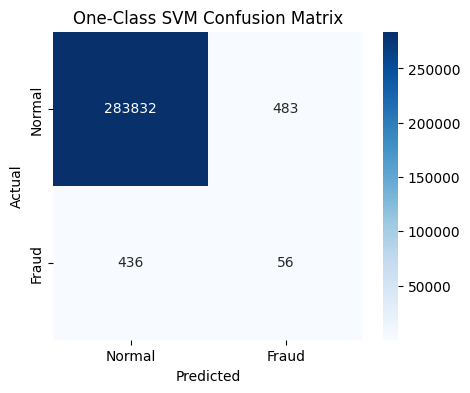

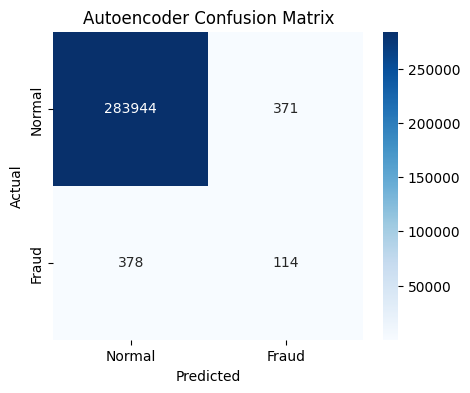

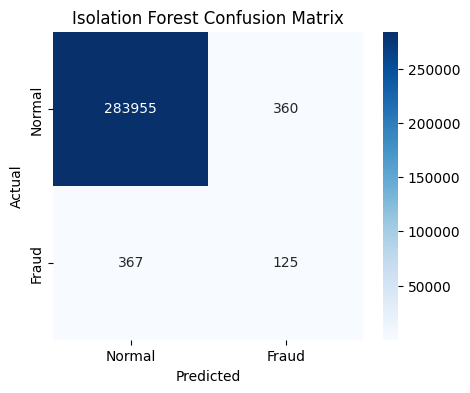

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# One-Class SVM confusion matrix
plot_confusion(y_true, y_pred_svm, "One-Class SVM Confusion Matrix")

# Autoencoder confusion matrix
plot_confusion(y_true, y_pred_ae, "Autoencoder Confusion Matrix")

# Isolation Forest confusion matrix
plot_confusion(y_true, y_pred_iso, "Isolation Forest Confusion Matrix")


### trying supervised models (Logistic Regression)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Features + Labels
X = data.drop('Class', axis=1)
y = data['Class']

# Scale features (important for LR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (stratify keeps fraud ratio the same)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix:
[[55474  1390]
 [    8    90]]


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
📊 Model Comparison:

                 Model  Accuracy  Precision  Recall  F1-Score
0        One-Class SVM    0.9496     0.0292  0.8776    0.0566
1     Isolation Forest    0.9980     0.3906  0.2551    0.3086
2          Autoencoder    0.9513     0.0302  0.8776    0.0584
3  Logistic Regression    0.9755     0.0608  0.9184    0.1141


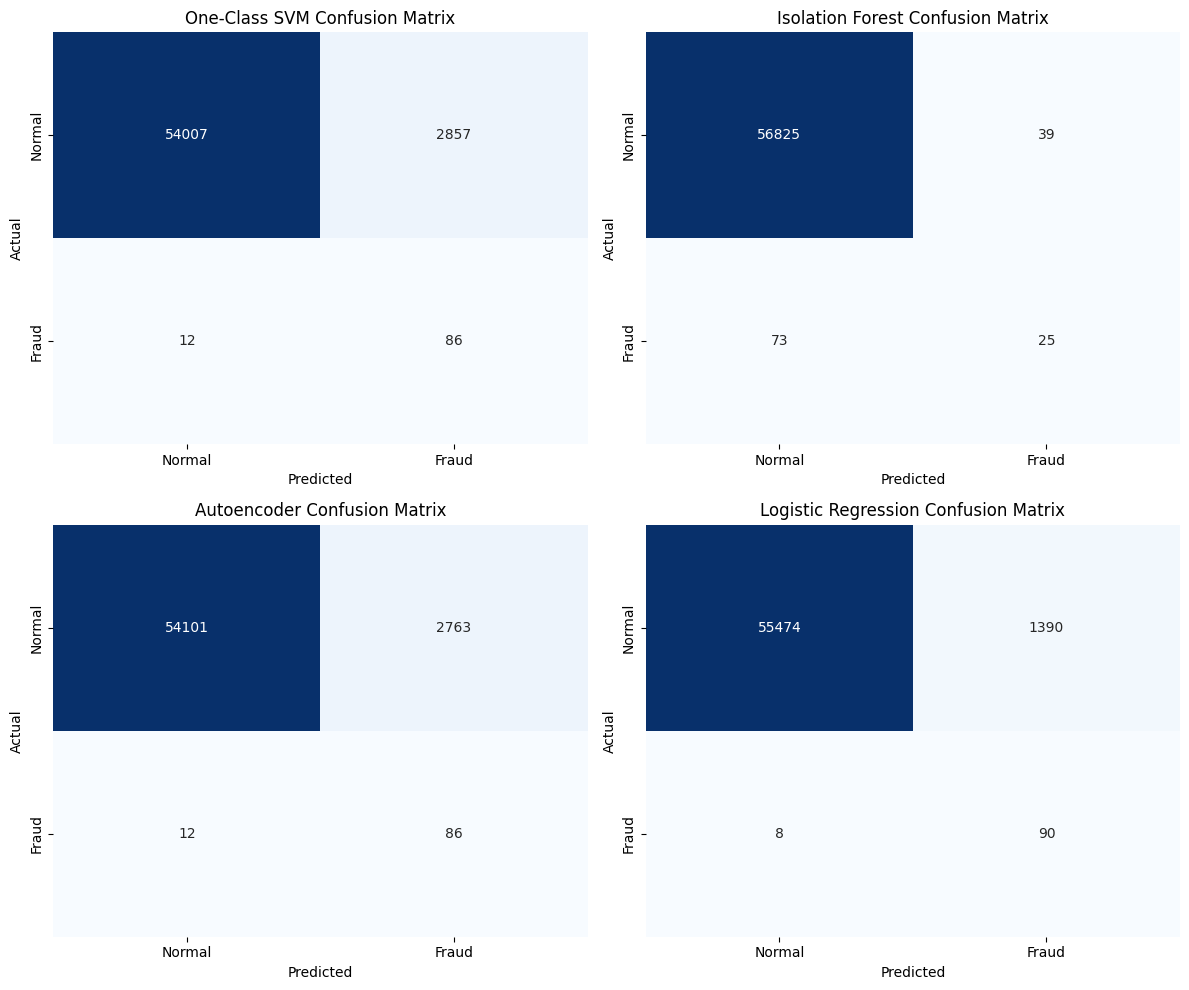

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# -------------------------------
# 1. Define and train models
# -------------------------------

# One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)
y_pred_svm = ocsvm.fit(X_train).predict(X_test)
y_pred_svm = [1 if p == -1 else 0 for p in y_pred_svm]   # convert: -1 = fraud, 1 = normal

# Isolation Forest
iforest = IsolationForest(contamination=0.001, random_state=42)
y_pred_iso = iforest.fit(X_train).predict(X_test)
y_pred_iso = [1 if p == -1 else 0 for p in y_pred_iso]   # convert: -1 = fraud, 1 = normal

# Autoencoder (assuming it's already built & compiled)
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = np.percentile(mse, 95)  # choose threshold
y_pred_ae = [1 if e > threshold else 0 for e in mse]

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# -------------------------------
# 2. Collect evaluation results
# -------------------------------
models = {
    "One-Class SVM": y_pred_svm,
    "Isolation Forest": y_pred_iso,
    "Autoencoder": y_pred_ae,
    "Logistic Regression": y_pred_lr
}

results = []
for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

results_df = pd.DataFrame(results)
print("📊 Model Comparison:\n")
print(results_df)

# -------------------------------
# 3. Plot confusion matrices
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

